# SmilePass Trajectory Recommondation System

Progress so far:
1. Data Cleaning and Modification
2. Clustering on whole data
3. Data Segmentation based on consistency
4. Deep learning mode on consistent groups

In this page, I'm going to construct a re-cap of my previous work with a clean and clear version. Then made some modification on clustering and data segmentation for the sake of next step's preparation.

The idea includes:
1. Conclude M18 and 19
2. Modify the way of data segmentation (v1-v4)
3. Other algorithms of clustering
4. Confirm how the recommendation system perform
5. Make sure the system is good for new data inputs

In [3]:
# Read Current Data (M19's way of defining v1, v2, v3
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
svd_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv"
# v1_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv"
# v2_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv"
# v3_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v3.csv"

df = pd.read_csv(full_dataset, encoding="Windows-1252")
# df_v1 = pd.read_csv(v1_data, encoding="Windows-1252")
# df_v2 = pd.read_csv(v2_data, encoding="Windows-1252")
# df_v3 = pd.read_csv(v3_data, encoding="Windows-1252")
df_svd = pd.read_csv(svd_data, encoding="Windows-1252")

C:\Users\frank\AppData\Local\Temp\ipykernel_10072\3081050375.py:8: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")


## Data Loading and Cleaning

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

In [4]:
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Define trash columns
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']

df = drop_high_nan_columns(df) 
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # age group preparation (modify to int)
df = days_cal_v2(df,'last_visit','first_visit','visit_period')

# # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"
df = one_hot_encode_procedure_and_treatment(df)
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)

C:\Users\frank\AppData\Local\Temp\ipykernel_10072\1647155174.py:2: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\help

- Create a complete dataset to reflect each patient_id's treatment pattern (aassuming all meta columns stand the same for each unique patient id)
- Applied Truncated SVD which is the best for sparse binary data of large sparse matrices.

Note: `final_df` is generated from whole dataset; `df_svd` is based on it. Replace it with any new version of dataset if needed

In [5]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

df_next = df.copy()
# Define Constant columns
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']

# Select relevant columns
base_cols = ['patient_id', 'procedure_age']
procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
df_subset = df_next[base_cols + procedure_cols].copy()
df_subset['procedure_age'] = df_subset['procedure_age'].astype(int) # procedure_age to int

# Melt one-hot to long format
df_long = df_subset.melt(
    id_vars=['patient_id', 'procedure_age'],
    value_vars=procedure_cols,
    var_name='procedure_code',
    value_name='occurred'
)

# Keep only rows where procedure occurred
df_long = df_long[df_long['occurred'] == 1]

# Create combined feature name
df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)

# Pivot to wide format
final_df = df_long.groupby(['patient_id', 'feature']).size().unstack(fill_value=0)
final_df = final_df.reset_index()

# Get metadata (take first row per patient) # may need further fixing if the information for such patient changed over times
patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
final_df = pd.merge(patient_meta, final_df, on='patient_id', how='left')

# columns to exclude from SVD
non_binary_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE','procedure_age', 'visit_period']
meta_df = final_df[non_binary_cols].copy()
binary_df = final_df.drop(columns=non_binary_cols)

# Apply TruncatedSVD on binary columns
X_sparse = csr_matrix(binary_df.values)
svd = TruncatedSVD(n_components=100, random_state=823)
X_svd = svd.fit_transform(X_sparse)
svd_features = pd.DataFrame(X_svd, columns=[f"SVD_{i+1}" for i in range(X_svd.shape[1])])
df_svd = pd.concat([meta_df.reset_index(drop=True), svd_features], axis=1)

In [14]:
df_svd.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\df_svd.csv', index=False)

- Dataframe for 17 age groups, start from 5-10, up to 85-90
- Dataframe for each age groups

Note: Change `df` to any version of `dataset` if needed

In [ ]:
# Key functions to separate the data in different year windows
import os

# 5 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        lower = (age // 5) * 5
        upper = lower + 5
        if lower > upper:
            return "invalid"
        return f"{lower}-{upper}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe 5 year"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    filename = f"{output_dir}/age_group_{group_name}.csv"
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")


# 1 year window
def age_to_group(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        return f"{age}"
    except:
        return "invalid"

df['age_group'] = df['procedure_age'].apply(age_to_group)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M18\Split dataframe yearly"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

### Data Segmentation

#### Divide patient-level treatment dataset into three groups (V1, V2, V3, v4) based on the continuity and duration of their visit history
Definitions:
- First Visit Date: Start of treatment history
- Last Visit Date: End of treatment history
- Procedure Data: The date which procedure occurred
- Max Gap: Largest time gap between consecutive visits
- Duration: Total time span = Last Visit Date - First Visit Date

V1 (Consistent long history): Max gap between visits is less or equal to 2 years, with total treatment of more or equal to 3 years.   
V2 (Consistent Short history): Max gap between visits is less than 2 years, with total treatment of less than 3 years.  
V3 (Inconsistent but Long History): Max gap is 2 years or more; Total duration is 7 years or more.    
V4 (Inconsistent and Short History): Everything else.  

In [ ]:
## Old classification stream
# df_next = df.copy() # for next step use
# def classify_patient(group):
#     procedure_dates = group.sort_values('procedure_date')['procedure_date']
    
#     # Visit span in years
#     span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

#     # Maximum time gap between consecutive visits
#     gaps = procedure_dates.diff().dropna().dt.days / 365.0
#     max_gap = gaps.max() if not gaps.empty else 0

#     # Classification
#     if span_years >= 1 and max_gap <= 2:
#         return 'V1'
#     elif span_years >= 7:
#         return 'V2'
#     else:
#         return 'V3'

# # Apply the classification
# patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
# patient_versions.columns = ['patient_id', 'version']

# # Merge version info back to full dataset (Treatment Based)
# df_next = df_next.merge(patient_versions, on='patient_id')

C:\Users\frank\AppData\Local\Temp\ipykernel_9708\163003166.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [6]:
# New classifiaction stream
df_next = df.copy()
def classify_patient(group):
    procedure_dates = group.sort_values('procedure_date')['procedure_date']

    # Calculate total treatment span in years
    span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

    # Calculate max gap between consecutive visits in years
    gaps = procedure_dates.diff().dropna().dt.days / 365.0
    max_gap = gaps.max() if not gaps.empty else 0

    # Classification rules
    if max_gap <= 2:
        if span_years >= 3:
            return 'V1'  # Consistent long history
        else:
            return 'V2'  # Consistent short history
    elif max_gap > 2 and span_years >= 7:
        return 'V3'  # Inconsistent but long history
    else:
        return 'V4'  # Inconsistent and short history (everything else)

# Apply the classification to each patient group
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']

# Merge version info back into the main dataset
df_next = df_next.merge(patient_versions, on='patient_id')

C:\Users\frank\AppData\Local\Temp\ipykernel_10072\2702337505.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [7]:
df_next['version'].value_counts()

version
V3    180491
V1    103641
V2     34236
V4     14147
Name: count, dtype: int64

In [8]:
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']
df_v1_v3 = df_next[df_next['version'].isin(['V1', 'V3'])]

In [11]:
df_v1.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_v1.csv")
df_v3.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_v3.csv")

In [10]:
df_v1_v3.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_v1_v3.csv")

In [17]:
df_v1_v3

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_13,treatment_category_14,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version
0,0,25.22,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V3
1,0,32.96,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V3
2,0,47.09,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V3
3,0,21.36,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V3
4,1,57.10,0,2007-07-11,2479,1939-01-21,1,0,1991-08-08,2019-04-17,...,False,False,False,False,False,False,False,False,False,V3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332510,1,25.22,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,V3
332511,1,96.26,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,V3
332512,4,23.66,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,False,False,V1
332513,3,87.06,0,1996-12-12,2679,1976-06-05,0,0,1991-12-10,2013-05-14,...,False,False,False,False,False,False,False,False,False,V3


C:\Users\frank\AppData\Local\Temp\ipykernel_11624\3372012186.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)


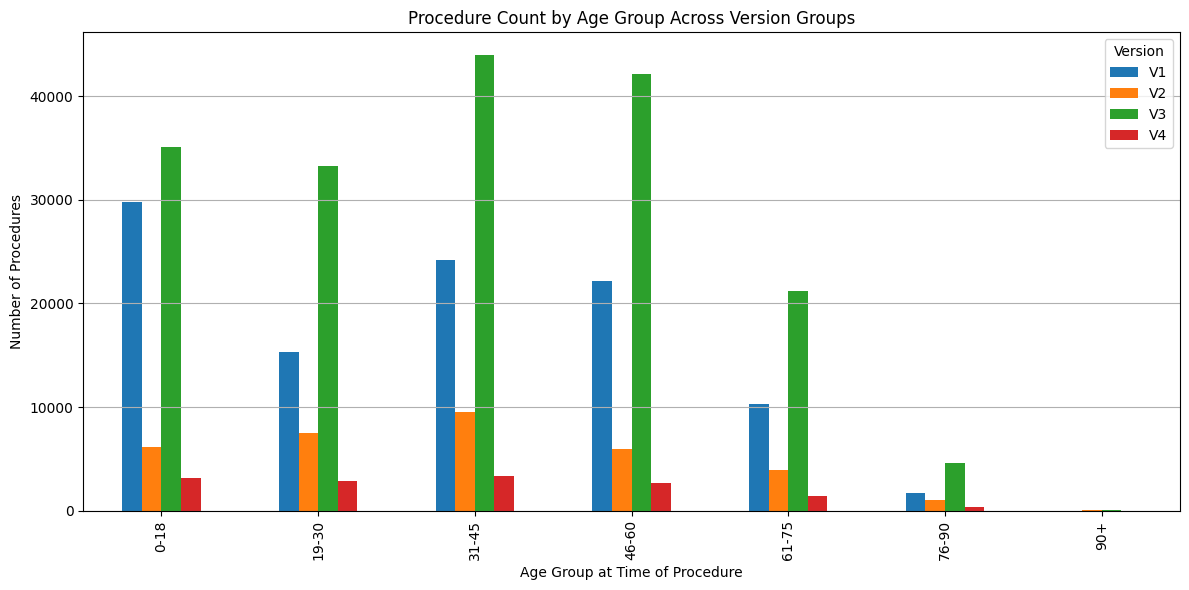

In [ ]:
# Calculate age at time of each procedure
df_next['age_at_procedure'] = (df_next['procedure_date'] - df_next['birth_date']).dt.days // 365

# Bucket into age groups
df_next['age_group'] = pd.cut(
    df_next['age_at_procedure'],
    bins=[0, 18, 30, 45, 60, 75, 90, 120],
    labels=['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+'])

# Count procedures per age group and version
age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)

# Plot
age_distribution.T.plot(kind='bar', figsize=(12, 6))
plt.title("Procedure Count by Age Group Across Version Groups")
plt.xlabel("Age Group at Time of Procedure")
plt.ylabel("Number of Procedures")
plt.grid(axis='y')
plt.legend(title='Version')
plt.tight_layout()
plt.show()

- V3 (Inconsistent, Long History) dominates across nearly all age groups, suggests many patients have long timelines but irregular visit patterns.
- V1 (Consistent, Long History) is the second largest group and it has strongest presence in 0–18 and 31–60 which reflects patients with reliable visit patterns and long history.
- V2, V4 may not be relevant data as they don't add value.
- Consider to combine v1 and v3...



##### Separate to yearly age-group files for v1, v3 and v1v3

In [22]:
# 1 year window
import os
def age_to_group_yearly(age):
    try:
        age = int(age)
        if age < 0:
            return "invalid"
        return f"{age}"
    except:
        return "invalid"

In [251]:
df_v1

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version,age_at_procedure,age_group
9,1,544.16,0,2007-07-10,6239,1968-07-15,3,0,1998-04-14,2022-07-13,...,False,False,False,False,False,False,False,V1,39,31-45
14,2,30.00,0,2007-07-10,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,V1,71,61-75
18,2,99.81,0,2001-10-22,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,V1,66,61-75
21,1,59.11,0,2007-07-10,9456,2003-10-15,5,0,2007-07-10,2024-10-19,...,False,False,False,False,False,False,False,V1,3,0-18
22,4,96.26,0,2007-07-09,5492,1960-08-11,0,0,1996-11-12,2024-07-18,...,False,False,False,False,False,False,False,V1,46,46-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332504,4,33.46,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,V1,46,46-60
332505,0,96.81,0,2000-09-30,8378,1999-07-27,0,0,2003-09-23,2009-12-08,...,False,False,False,False,False,False,False,V1,1,0-18
332506,0,96.81,0,2000-09-30,1165,1941-07-08,1,0,1989-07-25,2024-12-19,...,False,False,False,False,False,False,False,V1,59,46-60
332509,4,96.26,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,V1,46,46-60


In [257]:
df_v1['age_group'] = df_v1['procedure_age'].apply(age_to_group_yearly)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df_v1.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_v1_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\1704885489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1['age_group'] = df_v1['procedure_age'].apply(age_to_group_yearly)


Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_0.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_1.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_10.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_11.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_12.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_13.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_14.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_16.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1\age_group_v1_17.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Proj

In [ ]:
df_v3['age_group'] = df_v3['procedure_age'].apply(age_to_group_yearly)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df_v3.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_v3_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_11624\2122947709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3['age_group'] = df_v3['procedure_age'].apply(age_to_group_yearly)


Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_0.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_1.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_10.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_11.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_12.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_13.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_14.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_16.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3\age_group_v3_17.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Proj

In [ ]:
df_v1_v3['age_group'] = df_v1_v3['procedure_age'].apply(age_to_group_yearly)
output_dir = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3"
os.makedirs(output_dir, exist_ok=True)
# Split and save each group
for group_name, group_df in df_v1_v3.groupby('age_group'):
    if group_name == "invalid":
        continue  # Skip invalid entries
    filename = os.path.join(output_dir, f"age_group_v1v3_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_10364\2164586792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1_v3['age_group'] = df_v1_v3['procedure_age'].apply(age_to_group_yearly)


Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_0.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_1.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_10.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_11.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_12.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_13.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_14.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_16.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3\age_group_v1v3_17.csv
Sa

##### Perform SVD on v1, v3 and v1v3 dataset

In [12]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
# Shared constants
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city', 'state_y',
             'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']

non_binary_cols = meta_cols.copy()

def perform_svd_pipeline(df, name, n_components = 100):
    df_next = df.copy()
    
    # Select relevant columns
    base_cols = ['patient_id', 'procedure_age']
    procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
    df_subset = df_next[base_cols + procedure_cols].copy()
    df_subset['procedure_age'] = df_subset['procedure_age'].astype(int)

    # Melt one-hot to long format
    df_long = df_subset.melt(
        id_vars=['patient_id', 'procedure_age'],
        value_vars=procedure_cols,
        var_name='procedure_code',
        value_name='occurred'
    )
    df_long = df_long[df_long['occurred'] == 1]
    df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)

    # Pivot to wide format
    final_df = df_long.groupby(['patient_id', 'feature']).size().unstack(fill_value=0).reset_index()

    # Attach metadata
    patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
    final_df = pd.merge(patient_meta, final_df, on='patient_id', how='left')

    # Split for SVD
    meta_df = final_df[non_binary_cols].copy()
    binary_df = final_df.drop(columns=non_binary_cols)

    # Apply SVD
    X_sparse = csr_matrix(binary_df.values)
    svd = TruncatedSVD(n_components, random_state=823)
    X_svd = svd.fit_transform(X_sparse)
    svd_features = pd.DataFrame(X_svd, columns=[f"SVD_{i+1}" for i in range(X_svd.shape[1])])

    # Combine
    df_svd = pd.concat([meta_df.reset_index(drop=True), svd_features], axis=1)
    print(f"Completed SVD for {name}: {df_svd.shape[0]} patients, {df_svd.shape[1]} features")
    return df_svd

# Input dataframes
datasets = {
    "v1": df_v1,
    "v3": df_v3,
    "v1v3": df_v1_v3.copy()

}

svd_results = {}
for name, df in datasets.items():
    svd_results[name] = perform_svd_pipeline(df, name)

# Access results
df_svd_v1 = svd_results["v1"]
df_svd_v3 = svd_results["v3"]
df_svd_v1_v3 = svd_results["v1v3"]


Completed SVD for v1: 2404 patients, 111 features
Completed SVD for v3: 3164 patients, 111 features
Completed SVD for v1v3: 5568 patients, 111 features


In [13]:
df_svd_v1.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_svd_v1.csv")
df_svd_v3.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_svd_v3.csv")
df_svd_v1_v3.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\df_svd_v1_v3.csv")

End up with 2 key datasets:   
Dataset 1: 3 version of (v1, v3, v1v3) separated datasets which are split by age groups. (5-year or yearly)  
Dataset 2: df_SVD - Compact representation of each patient’s historical treatment behavior for full data, v1, v3, v1v3.  


## Unsupervised Learning Recommondation Model

#### Clustering Alogrithms functions

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Kmeans
def cluster_patients_kmeans(df_svd, n_clusters=6):
    # Select only the SVD columns
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Add cluster labels to the DataFrame
    df_svd['Kmeans_cluster'] = cluster_labels

    return df_svd, kmeans, scaler


# AgglomerativeClustering
def cluster_patients_agglomerative(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    agglo = AgglomerativeClustering(n_clusters=n_clusters)

    df_svd['Agg_cluster'] = agglo.fit_predict(X_scaled)

    return df_svd, agglo, scaler

# GMM
def cluster_patients_gmm(df_svd, n_clusters=6):
    svd_cols = [col for col in df_svd.columns if col.startswith("SVD_")]
    X = df_svd[svd_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    df_svd['gmm_cluster'] = gmm.fit_predict(X_scaled)

    return df_svd, gmm, scaler

- KMeans baseline  
Baseline clustering model fast and interpretable.  

- Gaussian Mixture Model (GMM) for soft, overlapping patterns  
Patient histories may overlap.  
Can model elliptical clusters, good for reduced features (like SVD).  
Helps find blurry boundaries.  

- Agglomerative Clustering for interpretable structure  
Good for visualizing treatment relationships or creating treatment hierarchies.  
Reveals hierarchical structure — can be useful if patient groups nest within others.  
Good for understanding group similarity.  

Metrics to Evaluate k:  
- Inertia (Elbow Method): How spread out the points are in their clusters
- Silhouette Score: How similar a point is to its own cluster to others
- Although GMM doesn't provide “inertia” directly like KMeans does, we can use the negative log-likelihood (-log_likelihood) as an analog for model fit. The more positive the log-likelihood, the better the model fits the data.
- Agglomerative Clustering does not have a inertia or log-likelihood (because it’s not a probabilistic model), we can simulate an “inertia-like” value using average within-cluster squared Euclidean distances — which mimics compactness like KMeans

In [49]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# KMeans
def grid_search_kmeans(df_svd, svd_prefix='SVD_', k_range=range(4, 11)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = StandardScaler().fit_transform(df_svd[svd_cols].values)

    inertias, silhouettes = [], []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))

    best_k = k_range[silhouettes.index(max(silhouettes))]
    best_model = KMeans(n_clusters=best_k, random_state=42).fit(X)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('KMeans: Inertia vs k')
    plt.xlabel('k')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouettes, marker='o')
    plt.title('KMeans: Silhouette Score vs k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return best_model, best_k, silhouettes

# GMM
def grid_search_gmm(df_svd, svd_prefix='SVD_', k_range=range(4, 11)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = StandardScaler().fit_transform(df_svd[svd_cols].values)

    inertias, silhouettes = [], []

    for k in k_range:
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        labels = gmm.fit_predict(X)
        score = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouettes.append(score)
        
        # Pseudo-inertia (negative log-likelihood * n_samples)
        inertia_like = -gmm.score(X) * len(X)
        inertias.append(inertia_like)

    best_k = k_range[silhouettes.index(max(silhouettes))]
    best_model = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42).fit(X)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('GMM: Inertia vs k')
    plt.xlabel('k')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouettes, marker='o')
    plt.title('GMM: Silhouette Score vs k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return best_model, best_k, silhouettes

# Agglomerative
def grid_search_agglomerative(df_svd, svd_prefix='SVD_', k_range=range(4, 11)):
    svd_cols = [col for col in df_svd.columns if col.startswith(svd_prefix)]
    X = StandardScaler().fit_transform(df_svd[svd_cols].values)

    inertias, silhouettes = [], []

    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X)
        score = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouettes.append(score)

        # Create Inertia: sum of squared distances to each cluster mean
        inertia = 0
        for cluster_id in np.unique(labels):
            cluster_points = X[labels == cluster_id]
            centroid = cluster_points.mean(axis=0)
            inertia += ((cluster_points - centroid) ** 2).sum()
        inertias.append(inertia)

    best_k = k_range[silhouettes.index(max(silhouettes))]
    best_model = AgglomerativeClustering(n_clusters=best_k).fit(X)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('Agg: Inertia vs k')
    plt.xlabel('k')
    plt.ylabel('Inertia')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouettes, marker='o')
    plt.title('Agg: Silhouette Score vs k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return best_model, best_k, silhouettes


#### Apply clustering


 Running clustering grid search for: v1


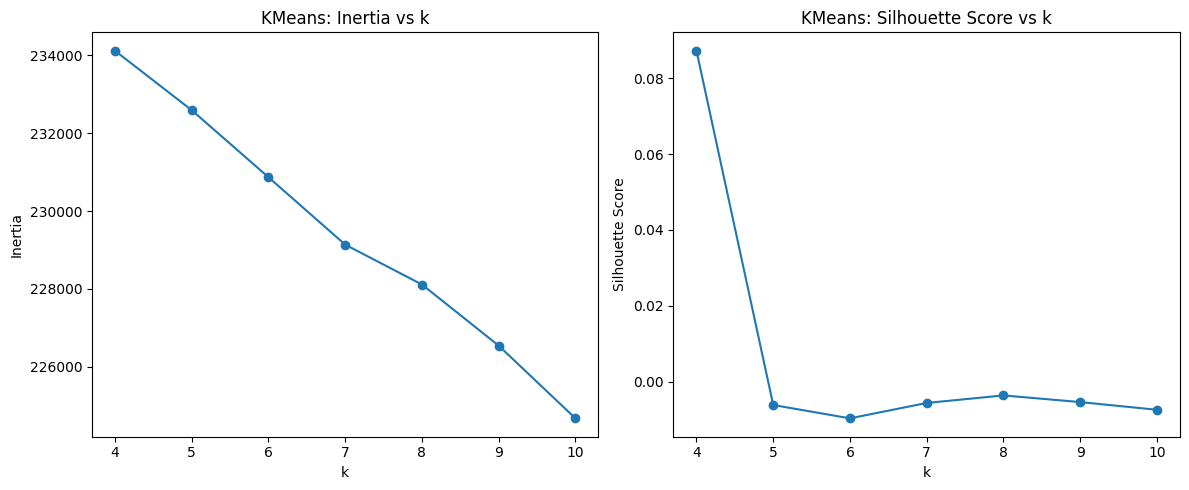

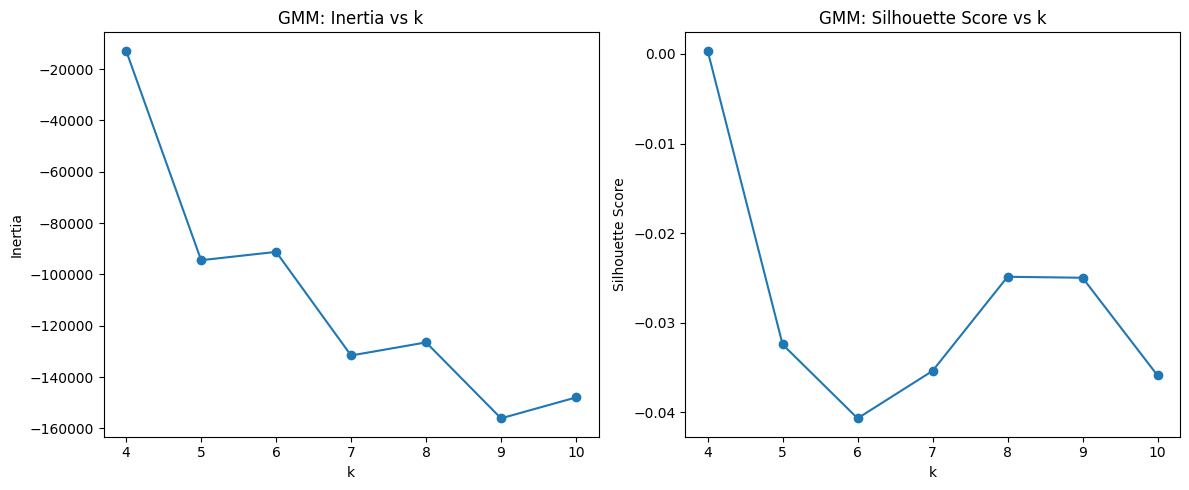

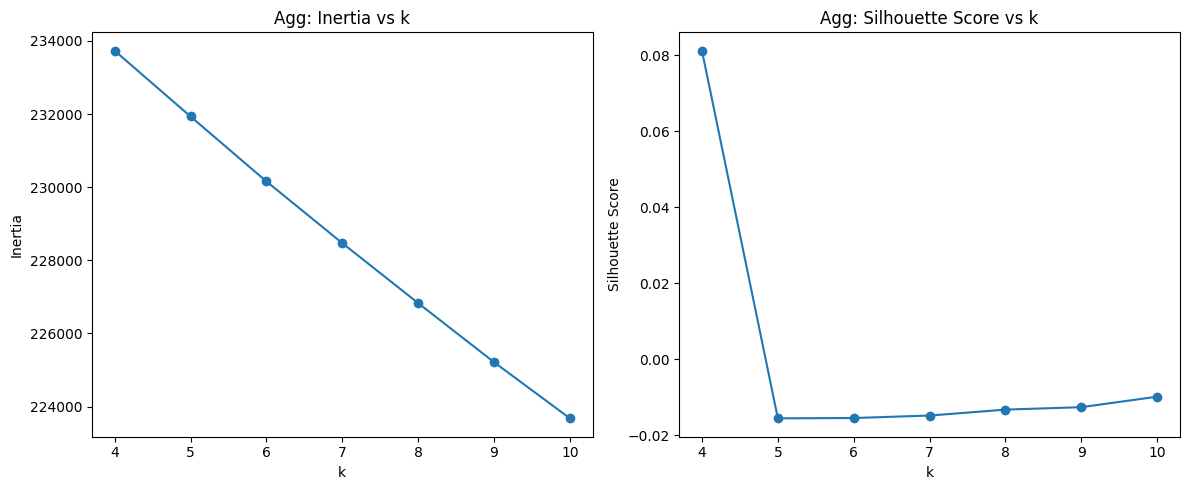

Clustering for v1 — Best Ks: KMeans=4, GMM=4, Agg=4

 Running clustering grid search for: v3


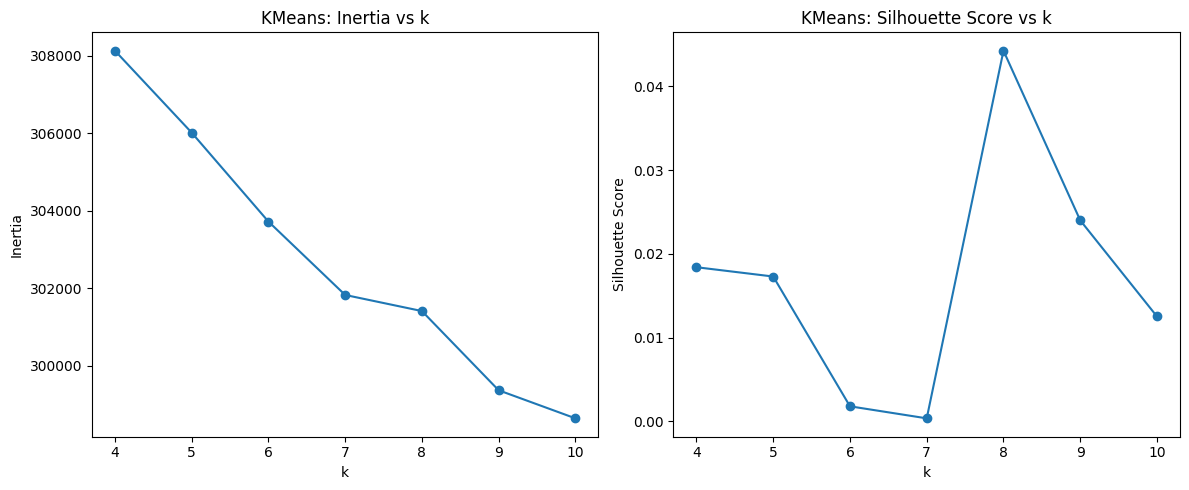

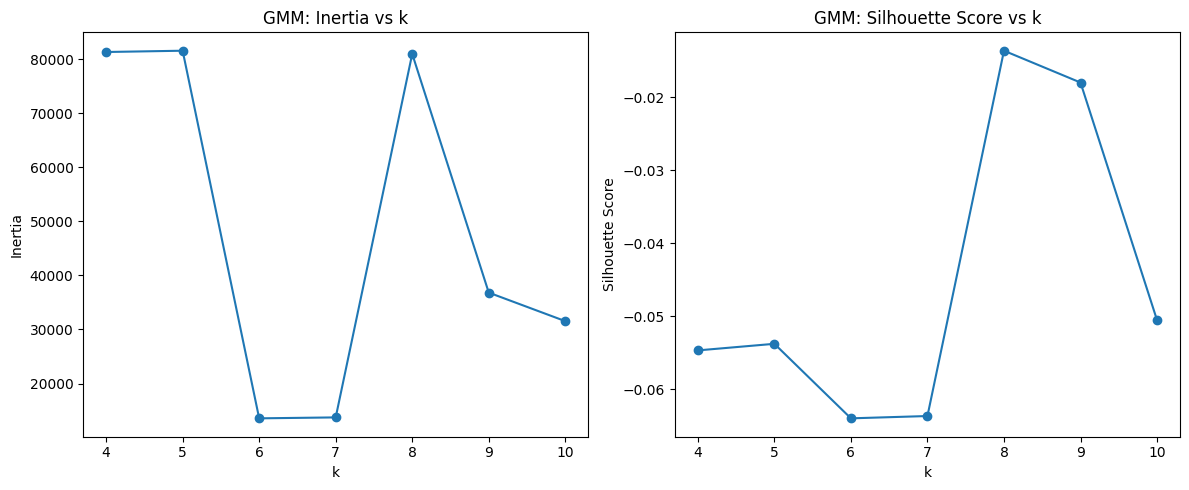

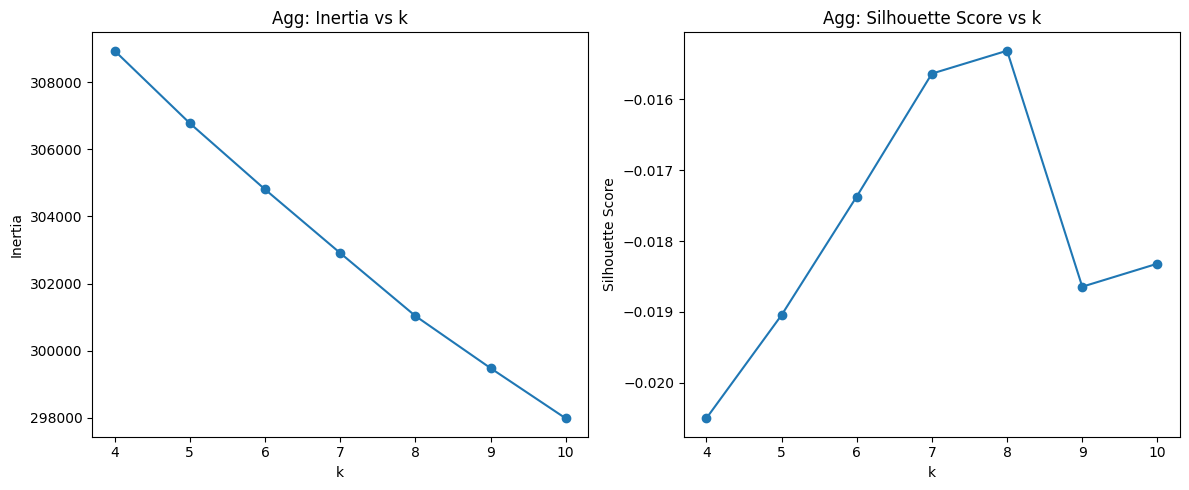

Clustering for v3 — Best Ks: KMeans=8, GMM=8, Agg=8

 Running clustering grid search for: v1v3


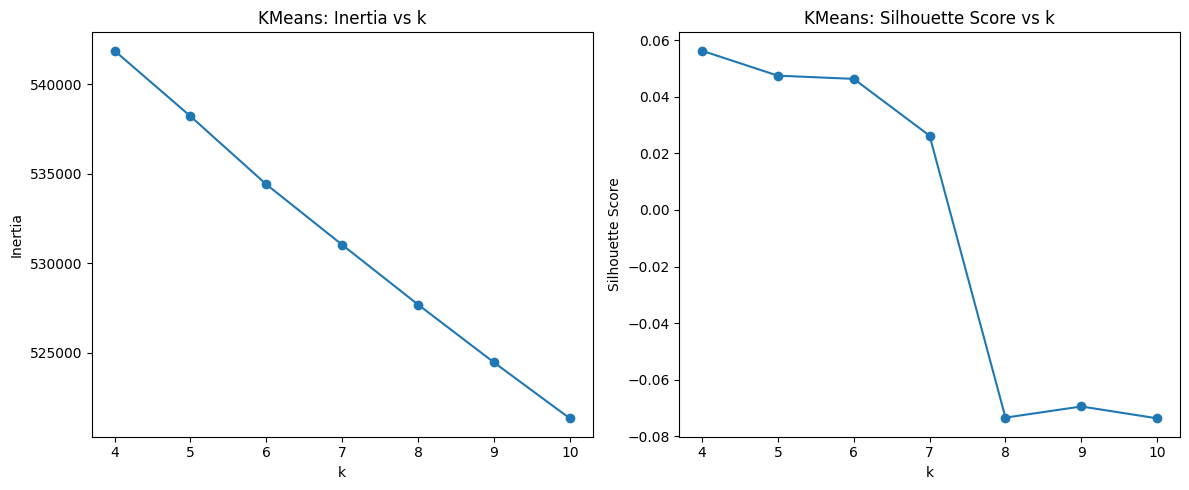

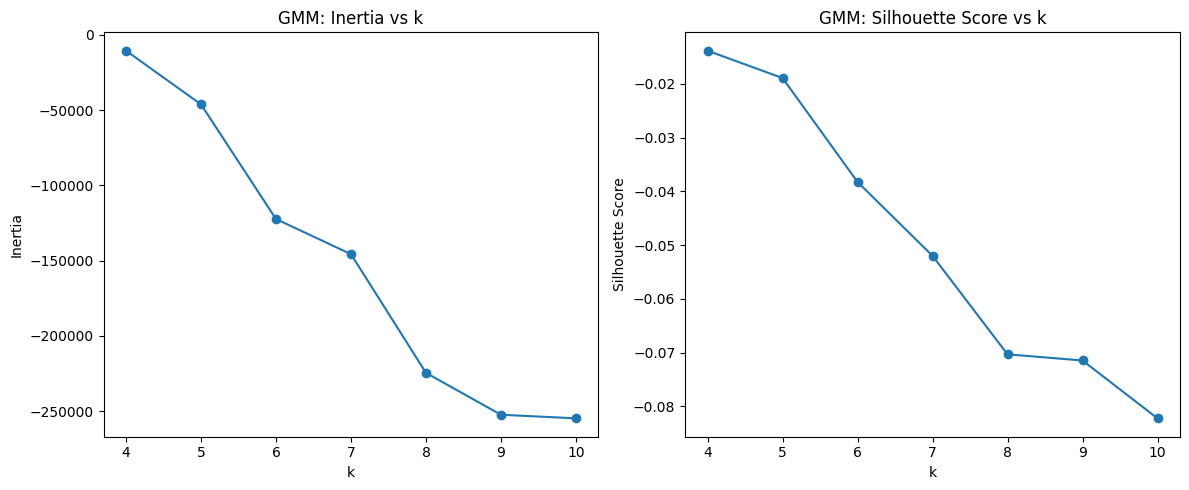

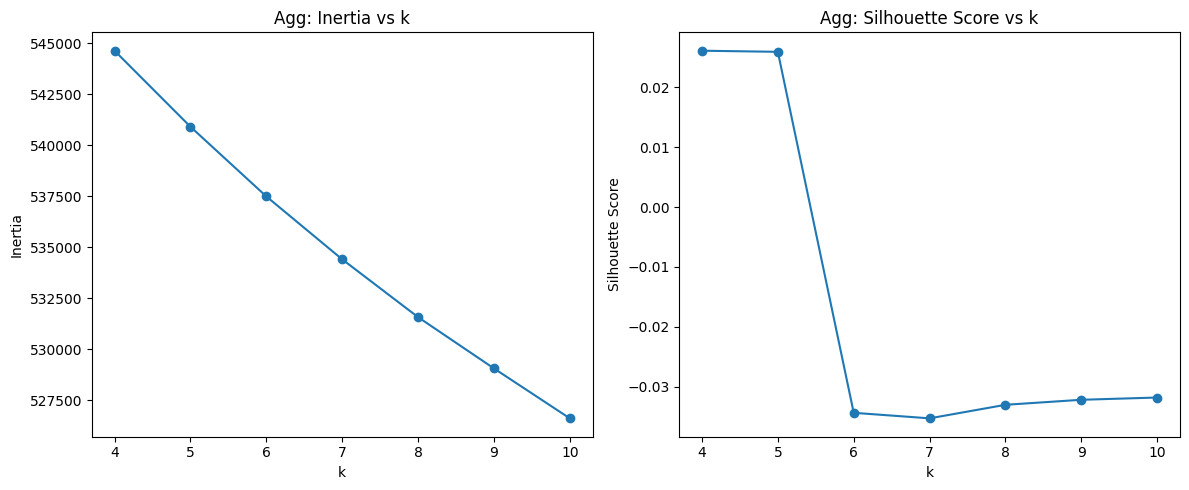

Clustering for v1v3 — Best Ks: KMeans=4, GMM=4, Agg=4


In [50]:
svd_datasets = {
    # "Full": df_svd,
    "v1": df_svd_v1,
    "v3": df_svd_v3,
    "v1v3": df_svd_v1_v3
}
clustering_results = {}

for name, df_svd in svd_datasets.items():
    print(f"\n Running clustering grid search for: {name}")

    # KMeans
    kmeans_model, best_k_kmeans, kmeans_scores = grid_search_kmeans(df_svd)

    # GMM
    gmm_model, best_k_gmm, gmm_scores = grid_search_gmm(df_svd)

    # Agglomerative
    agg_model, best_k_agg, agg_scores = grid_search_agglomerative(df_svd)

    # Store results
    clustering_results[name] = {
        "kmeans": (kmeans_model, best_k_kmeans, kmeans_scores),
        "gmm": (gmm_model, best_k_gmm, gmm_scores),
        "agg": (agg_model, best_k_agg, agg_scores)
    }

    print(f"Clustering for {name} — Best Ks: KMeans={best_k_kmeans}, GMM={best_k_gmm}, Agg={best_k_agg}")

In [51]:
clustering_results['v1']

{'kmeans': (KMeans(n_clusters=4, random_state=42),
  4,
  [0.08725547215465641,
   -0.0061871517753974824,
   -0.009702284452566094,
   -0.005645957246150024,
   -0.0036566997561445895,
   -0.0054157520009444435,
   -0.007444092366241572]),
 'gmm': (GaussianMixture(n_components=4, random_state=42),
  4,
  [0.0003661488086232509,
   -0.03244008267944085,
   -0.040688623320666466,
   -0.03539047080051373,
   -0.02488071011630236,
   -0.024986191089226957,
   -0.035893289725370835]),
 'agg': (AgglomerativeClustering(n_clusters=4),
  4,
  [0.08120119122374385,
   -0.01555917170681569,
   -0.015472445730199399,
   -0.014822442623696858,
   -0.013265614867793167,
   -0.012618769769797365,
   -0.00985524807850474])}

## Using v1v3 data as example for next steps

### Create cluster v.s patient_ids map

In [64]:
df_sv_kmeans, kmeans, scaler = cluster_patients_kmeans(df_svd_v1_v3, n_clusters=4)
cluster_map_kmeans = df_sv_kmeans[['patient_id', 'Kmeans_cluster']]
cluster_map_kmeans

,patient_id,Kmeans_cluster
0,1,3
1,2,3
2,3,3
3,4,3
4,5,3
...,...,...
5563,12838,3
5564,12844,3
5565,12845,2
5566,12873,3


In [65]:
df_sv_gmm, gmm, scaler_gmm = cluster_patients_gmm(df_svd_v1_v3, n_clusters=4)
cluster_map_gmm = df_sv_gmm[['patient_id', 'gmm_cluster']]
cluster_map_gmm

,patient_id,gmm_cluster
0,1,1
1,2,2
2,3,0
3,4,3
4,5,0
...,...,...
5563,12838,0
5564,12844,0
5565,12845,2
5566,12873,2


In [68]:
df_sv_agg, agg, scaler_agg = cluster_patients_agglomerative(df_svd_v1_v3, n_clusters=4)
cluster_map_agg = df_sv_agg[['patient_id', 'Agg_cluster']]
cluster_map_agg

,patient_id,Agg_cluster
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
...,...,...
5563,12838,1
5564,12844,1
5565,12845,0
5566,12873,0


### Add the cluster label from svd data into each age-group files, so every patient in each file knows their cluster.

In [ ]:
def annotate_age_group_files(folder_path, cluster_map_kmeans, cluster_map_gmm, cluster_map_agg):
    age_group_data = {}

    for file in sorted(os.listdir(folder_path)):
        if not file.endswith(".csv"):
            continue

        # Extract age from filename
        age = int(file.split("_")[-1].replace(".csv", ""))
        file_path = os.path.join(folder_path, file)

        # Read age group data
        df = pd.read_csv(file_path)
        df = df.merge(cluster_map_kmeans, on='patient_id', how='left')
        df = df.merge(cluster_map_gmm, on='patient_id', how='left')
        df = df.merge(cluster_map_agg, on='patient_id', how='left')
        age_group_data[age] = df
        
    return age_group_data


In [ ]:
# folder_path_v1 = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1"
# folder_path_v3 = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v3"
folder_path_v1v3 = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M21\Split dataframe yearly v1v3"

# annotate_age_group_files(folder_path_v1, cluster_map_kmeans, cluster_map_gmm, cluster_map_agg)
# annotate_age_group_files(folder_path_v3, cluster_map_kmeans, cluster_map_gmm, cluster_map_agg)
annotated_v1v3 = annotate_age_group_files(folder_path_v1v3, cluster_map_kmeans, cluster_map_gmm, cluster_map_agg)

In [ ]:
# example of annotated_v1v3[age]
annotated_v1v3[40]

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version,age_group,Kmeans_cluster,gmm_cluster,Agg_cluster
0,3,45.00,0,1997-07-03,3737,1957-05-06,2,0,1993-10-13,2012-04-19,...,False,False,False,False,False,V3,40,3,2,0
1,1,351.98,0,2007-06-25,8893,1966-11-16,8,0,2004-11-11,2011-10-11,...,False,False,False,False,False,V1,40,3,1,0
2,4,23.66,0,2007-06-12,6055,1966-09-25,19,0,1997-11-13,2024-11-06,...,False,False,False,False,False,V3,40,1,1,0
3,1,177.41,0,2007-04-14,8893,1966-11-16,8,0,2004-11-11,2011-10-11,...,False,False,False,False,False,V1,40,3,1,0
4,1,174.45,0,2007-05-16,2061,1966-08-30,0,0,1990-11-01,2024-09-23,...,False,False,False,False,False,V3,40,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,1,84.91,0,2007-09-26,9318,1967-09-19,81,0,2006-05-04,2017-06-29,...,False,False,False,False,False,V1,40,3,1,0
4819,1,174.45,0,2007-09-19,8550,1967-03-15,9,0,2004-01-16,2024-07-16,...,False,False,False,False,False,V3,40,1,1,0
4820,2,19.36,0,2000-03-29,5685,1960-03-23,0,0,1997-02-03,2007-09-13,...,False,False,False,False,False,V3,40,1,1,0
4821,3,94.83,0,1999-08-31,3315,1959-04-07,0,0,1995-12-04,2024-09-11,...,False,False,False,False,False,V3,40,3,1,1


### Build Trajectory Dictionary

In [81]:
from collections import defaultdict

def build_trajectory_dict_past(clustered_folder, procedure_prefix="procedure_code_y_"):
    """
    Create a nested dictionary mapping cluster_id to age to list of top 5 procedure codes.
    """
    # Initialize Dictionary
    trajectory_dict = defaultdict(dict)

    # Goes through each .csv file in the folder
    for file in sorted(os.listdir(clustered_folder)):
        # Extract age from filename
        try:
            age = int(file.replace("age_group_", "").replace("_clustered.csv", "").replace(".csv", ""))
        except ValueError:
            continue

        df = pd.read_csv(os.path.join(clustered_folder, file))
        procedure_cols = [col for col in df.columns if col.startswith(procedure_prefix)]

        for cluster_id in df['cluster'].dropna().unique():
            sub_df = df[df['cluster'] == cluster_id]
            if sub_df.empty:
                continue

            proc_counts = sub_df[procedure_cols].sum().sort_values(ascending=False)
            top_procs = [col.replace(procedure_prefix, "") for col in proc_counts.head(5).index]
            trajectory_dict[int(cluster_id)][age] = top_procs

    return trajectory_dict


def build_trajectory_dict(annotated_age_groups, cluster_col, procedure_prefix="procedure_code_y_"):
    """
    trajectory_dict[cluster][age] = top procedures (list)
    """
    trajectory_dict = defaultdict(dict)

    for age, df in annotated_age_groups.items():
        procedure_cols = [col for col in df.columns if col.startswith(procedure_prefix)]

        for cluster_id in df[cluster_col].dropna().unique():
            sub_df = df[df[cluster_col] == cluster_id]
            if sub_df.empty:
                continue

            proc_counts = sub_df[procedure_cols].sum().sort_values(ascending=False)
            top_procs = [col.replace(procedure_prefix, "") for col in proc_counts.head(5).index]
            trajectory_dict[int(cluster_id)][age] = top_procs

    return trajectory_dict


In [83]:
trajectory_dict_v1v3_kmeans = build_trajectory_dict(annotated_v1v3, cluster_col="Kmeans_cluster")
trajectory_dict_v1v3_gmm = build_trajectory_dict(annotated_v1v3, cluster_col="gmm_cluster")
trajectory_dict_v1v3_agg = build_trajectory_dict(annotated_v1v3, cluster_col="Agg_cluster")

Goal: trajectory_dict[cluster_id][age] = ["procedure_code1", "procedure_code2", ...]

In [85]:
trajectory_dict_v1v3_gmm[2]

{28: ['1203', '43400', '11303', '1011', '49101'],
 29: ['12400', '11300', '2600', '11303', '2112'],
 30: ['2142', '2112', '1203', '43412', '2601'],
 31: ['2142', '43412', '1103', '11303', '12101'],
 32: ['2142', '43413', '2112', '12101', '1203'],
 33: ['12101', '1103', '2142', '2112', '2601'],
 34: ['2142', '12101', '2144', '43413', '11303'],
 35: ['12101', '43412', '2144', '1103', '1203'],
 36: ['12101', '1103', '2142', '2601', '2144'],
 37: ['12101', '2144', '1103', '2601', '1203'],
 38: ['12101', '2144', '1103', '2601', '1203'],
 39: ['12101', '2144', '1204', '1103', '43413'],
 40: ['12101', '2144', '1204', '11113', '2601'],
 41: ['12101', '1204', '2144', '11114', '11113'],
 42: ['12101', '1204', '2144', '11114', '11113'],
 43: ['12101', '1204', '11114', '11113', '2144'],
 44: ['12101', '1204', '11113', '11114', '2144'],
 45: ['12101', '1204', '11114', '11113', '2144'],
 46: ['12101', '11113', '11114', '1204', '2144'],
 47: ['12101', '1204', '11113', '11114', '2144'],
 48: ['11113',

In [88]:
trajectory_dict_v1v3_gmm[2][28]

['1203', '43400', '11303', '1011', '49101']

In [95]:
trajectory_dict_v1v3_agg[0]

{10: ['2142', '11302', '12101', '2601', '1204'],
 11: ['11303', '2142', '1102', '2601', '12101'],
 12: ['11303', '2142', '13401', '23321', '12101'],
 13: ['11303', '2142', '11302', '13401', '2601'],
 14: ['11303', '2142', '2601', '12101', '2112'],
 15: ['11303', '2142', '12101', '2601', '23321'],
 16: ['11303', '2142', '12101', '2601', '11111'],
 17: ['11303', '2142', '12101', '2601', '1202'],
 18: ['11303', '2142', '12101', '2601', '1103'],
 19: ['11303', '2142', '2601', '12101', '2144'],
 2: ['1101', '11107', '1202', '11101', '51711'],
 20: ['12101', '11112', '1204', '2142', '2144'],
 21: ['12101', '1204', '2142', '11112', '2601'],
 22: ['12101', '1204', '2144', '11112', '2142'],
 23: ['1204', '12101', '2142', '2144', '11113'],
 24: ['12101', '1204', '11113', '2142', '2144'],
 25: ['12101', '1204', '2142', '2144', '11113'],
 26: ['12101', '1204', '2144', '11112', '11113'],
 27: ['11113', '12101', '2144', '1204', '2142'],
 28: ['12101', '1204', '11113', '2144', '2142'],
 29: ['12101',

### Weighted Recommendation (Similarity Scoring)

In [125]:
def calculate_similarity(row, target_row, feature_weights):
    score = 0
    for feature, weight in feature_weights.items():
        if feature in row and feature in target_row:
            score += weight * (row[feature] == target_row[feature])
    return score

In [ ]:
def recommend_weighted_procedures(
    patient_id,
    current_age,
    df_svd,
    annotated_age_groups,
    cluster_col,
    procedure_prefix="procedure_code_y_",
    top_n=5):

    # Define feature weight
    feature_weights = {"city": 1.0, "state": 0.5, "treatment_category": 1.5}

    # Retrieve patient info and their assigned cluster
    patient_info = df_svd[df_svd['patient_id'] == patient_id].iloc[0]
    cluster = patient_info[cluster_col]

    # Find the next age's data
    next_age = current_age + 1
    if next_age not in annotated_age_groups:
        return []
    df_next_age = annotated_age_groups[next_age]

    # Filter to patients in the same cluster
    cluster_peers = df_next_age[df_next_age[cluster_col] == cluster]
    if cluster_peers.empty:
        return []

    # Compute similarity scores for all peers
    cluster_peers = cluster_peers.copy()
    cluster_peers["similarity"] = cluster_peers.apply(lambda row: calculate_similarity(row, patient_info, feature_weights), axis=1)

    # Identify procedure code columns
    procedure_cols = [col for col in cluster_peers.columns if col.startswith(procedure_prefix)]

    # Compute weighted frequency score for each procedure
    weighted_scores = {}
    for _, row in cluster_peers.iterrows():
        for col in procedure_cols:
            weighted_scores[col] = weighted_scores.get(col, 0) + row[col] * row["similarity"]

    # Rank and return the top N procedure codes
    sorted_procedures = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [col.replace(procedure_prefix, "") for col, _ in sorted_procedures[:top_n]]

    return sorted_procedures, recommendations

In [127]:
recommendations_34 = recommend_weighted_procedures(
    patient_id=12131,
    current_age=34,
    df_svd=df_svd_v1_v3,
    annotated_age_groups=annotated_v1v3,
    cluster_col="Kmeans_cluster"
)

In [128]:
recommendations_34

([('procedure_code_y_11113', 16.0),
  ('procedure_code_y_2144', 14.0),
  ('procedure_code_y_1103', 10.0),
  ('procedure_code_y_1202', 9.0),
  ('procedure_code_y_2113', 9.0),
  ('procedure_code_y_2601', 9.0),
  ('procedure_code_y_12111', 9.0),
  ('procedure_code_y_11107', 8.0),
  ('procedure_code_y_23321', 5.0),
  ('procedure_code_y_23111', 4.0),
  ('procedure_code_y_11101', 3.0),
  ('procedure_code_y_11117', 3.0),
  ('procedure_code_y_2143', 2.0),
  ('procedure_code_y_12113', 2.0),
  ('procedure_code_y_20111', 2.0),
  ('procedure_code_y_23114', 2.0),
  ('procedure_code_y_23322', 2.0),
  ('procedure_code_y_1205', 1.0),
  ('procedure_code_y_2111', 1.0),
  ('procedure_code_y_2112', 1.0),
  ('procedure_code_y_2114', 1.0),
  ('procedure_code_y_11114', 1.0),
  ('procedure_code_y_23113', 1.0),
  ('procedure_code_y_23224', 1.0),
  ('procedure_code_y_23323', 1.0),
  ('procedure_code_y_23602', 1.0),
  ('procedure_code_y_27211', 1.0),
  ('procedure_code_y_94303', 1.0),
  ('procedure_code_y_99111'

### Model Validation Check (Informal)

In [176]:
def visualize_patient_trajectory_alignment(
    patient_id,
    df_svd,
    annotated_age_groups,
    recommendation_func,
    start_age,
    end_age,
    cluster_col="Kmeans_cluster",
    procedure_prefix="procedure_code_y_",
    top_n=5,
    **kwargs
):
    """
    Plot actual vs. predicted trajectory for a patient from start_age to end_age,
    using a recommendation function that returns (score_dict, recommendations).
    """
    if patient_id not in df_svd['patient_id'].values:
        print(f"Patient {patient_id} not found in df_svd.")
        return

    actual = []
    predicted = []
    age_range = list(range(start_age, end_age + 1))

    for age in age_range:
        # Get actual procedures at this age
        actual_df = annotated_age_groups.get(age, pd.DataFrame())
        actual_row = actual_df[actual_df['patient_id'] == patient_id]

        if not actual_row.empty:
            procs = [
                col.replace(procedure_prefix, "") for col in actual_row.columns
                if col.startswith(procedure_prefix) and actual_row[col].values[0] == 1
            ]
            actual.append(", ".join(procs) if procs else "None")
        else:
            actual.append("None")

        # Predict procedures for next age
        recs = recommendation_func(
            patient_id=patient_id,
            current_age=age,
            df_svd=df_svd,
            annotated_age_groups=annotated_age_groups,
            cluster_col=cluster_col,
            procedure_prefix=procedure_prefix,
            top_n=top_n,
            **kwargs
        )
        predicted.append(", ".join(recs) if recs else "None")

    # Plotting the trajectory
    plt.figure(figsize=(14, 6))
    plt.plot(age_range, [1] * len(age_range), "o-", label="Actual", color="blue")
    plt.plot(age_range, [0.5] * len(age_range), "s-", label="Predicted", color="orange")

    for i, (a, p) in enumerate(zip(actual, predicted)):
        plt.text(age_range[i], 1.05, a, ha="center", fontsize=8, rotation=45)
        plt.text(age_range[i], 0.3, p, ha="center", fontsize=8, rotation=45)

    plt.title(f"Trajectory Alignment for Patient {patient_id}")
    plt.yticks([])
    plt.xlabel("Age")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
def recommend_weighted_procedures(
    patient_id,
    current_age,
    df_svd,
    annotated_age_groups,
    cluster_col,
    procedure_prefix="procedure_code_y_",
    top_n=5):

    # Define feature weight
    feature_weights = {"city": 1.0, "state": 0.5, "treatment_category": 1.5}

    # Retrieve patient info and their assigned cluster
    patient_info = df_svd[df_svd['patient_id'] == patient_id].iloc[0]
    cluster = patient_info[cluster_col]

    # Find the next age's data
    next_age = current_age + 1
    if next_age not in annotated_age_groups:
        return []
    df_next_age = annotated_age_groups[next_age]

    # Filter to patients in the same cluster
    cluster_peers = df_next_age[df_next_age[cluster_col] == cluster]
    if cluster_peers.empty:
        return []

    # Compute similarity scores for all peers
    cluster_peers = cluster_peers.copy()
    cluster_peers["similarity"] = cluster_peers.apply(lambda row: calculate_similarity(row, patient_info, feature_weights), axis=1)

    # Identify procedure code columns
    procedure_cols = [col for col in cluster_peers.columns if col.startswith(procedure_prefix)]

    # Compute weighted frequency score for each procedure
    weighted_scores = {}
    for _, row in cluster_peers.iterrows():
        for col in procedure_cols:
            weighted_scores[col] = weighted_scores.get(col, 0) + row[col] * row["similarity"]

    # Rank and return the top N procedure codes
    sorted_procedures = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [col.replace(procedure_prefix, "") for col, _ in sorted_procedures[:top_n]]

    return recommendations

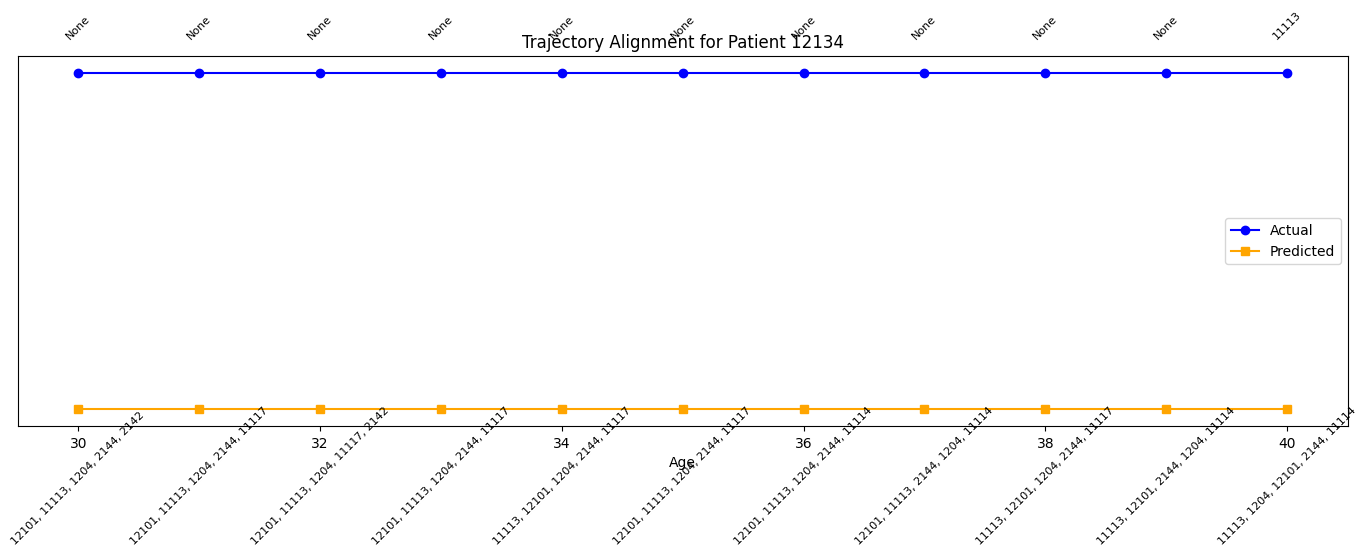

In [177]:
visualize_patient_trajectory_alignment(
    patient_id=12134,
    df_svd=df_svd_v1_v3,
    annotated_age_groups=annotated_v1v3,
    recommendation_func=recommend_weighted_procedures_1,
    start_age=30,
    end_age=40,
)

### Weighted based on type (consistency)

## Deep Learning (MLP/LSTM) cannot be applied by now as the data is not adqueate